In [1]:
import src.acquire
import src.prepare
import src.explore
import src.model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


In [2]:
path='zillow_df.csv'

df, X_train_explore, \
    X_train_scaled, y_train, \
    X_validate_scaled, y_validate, \
    X_test_scaled, y_test = src.prepare.wrangle_zillow(path)

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((12216, 12), (5236, 12), (4364, 12))

In [3]:
X_train_explore.shape

(12216, 20)

In [4]:
X_train_explore

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplace,garage,hottub_spa,latitude,longitude,lotsizesquarefeet,poolcnt,roomcnt,taxvaluedollarcnt,taxamount,zip,useid,year,zip_cc,useid_cc,year_cc
4948,0.0,0.0,2676.0,6059.0,0.0,0.0,0.0,33469340.0,-117693487.0,4666.0,0.0,0.0,309966.0,3168.92,96961.0,248.0,1972.0,288,2,85
20888,4.0,5.0,3434.0,6059.0,0.0,2.0,1.0,33611772.0,-117849046.0,12100.0,1.0,9.0,2272777.0,24201.38,96957.0,261.0,1972.0,285,4,85
6222,2.0,3.0,1837.0,6037.0,0.0,0.0,0.0,34151817.0,-118404542.0,8312.0,1.0,0.0,953318.0,11535.22,96449.0,261.0,1951.0,237,4,64
16476,4.0,4.0,2612.0,6037.0,0.0,0.0,0.0,34482284.0,-118159143.0,110539.0,1.0,0.0,526078.0,6194.31,97298.0,261.0,1986.0,370,4,99
19108,2.0,3.0,1332.0,6037.0,0.0,0.0,0.0,34030260.0,-118363871.0,4798.0,0.0,0.0,193721.0,2488.42,95997.0,246.0,1966.0,14,0,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12963,3.0,4.0,3204.0,6059.0,0.0,2.0,1.0,33573409.0,-117682233.0,9750.0,1.0,0.0,1024984.0,10579.94,96971.0,261.0,1989.0,296,4,102
8790,2.0,3.0,1774.0,6037.0,0.0,0.0,0.0,33727704.0,-118311665.0,10634.0,0.0,0.0,905025.0,11004.24,96222.0,261.0,1959.0,140,4,72
13792,1.0,2.0,996.0,6037.0,0.0,0.0,0.0,33992637.0,-118437879.0,5638.0,0.0,0.0,250382.0,3020.60,96047.0,261.0,1947.0,55,4,60
4440,3.0,4.0,3106.0,6037.0,0.0,0.0,0.0,34153402.0,-118770966.0,6039.0,1.0,0.0,407679.0,4860.18,96336.0,269.0,1986.0,186,9,99


In [5]:
X_train_scaled.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fireplace', 'garage', 'hottub_spa', 'lotsizesquarefeet', 'poolcnt',
       'roomcnt', 'zip_cc', 'useid_cc', 'year_cc'],
      dtype='object')

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success"></div>

# Explore

MVP- 3 Features
1. calculatedfinishedsquarefeet
2. bedroomcnt
3. bathroomcnt

Target = taxvaluedollarcnt

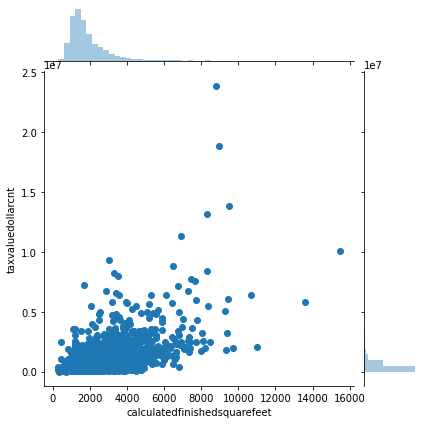

In [7]:
# Visualize relationship between square feet and tax value (Continuous and Continuous)
sns.jointplot(x='calculatedfinishedsquarefeet',y='taxvaluedollarcnt', data=X_train_explore)
plt.show()

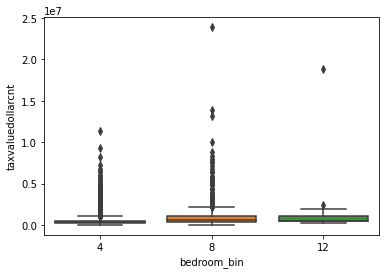

In [8]:
# Visualize relationship between bedroom count and tax value (Continuous and Categorical)
X_train_explore['bedroom_bin'] = pd.cut(X_train_explore.bedroomcnt, bins=[0, 4, 8, 12], labels=['4', '8', '12'])
sns.boxplot(data=X_train_explore, y='taxvaluedollarcnt', x='bedroom_bin')
plt.show()

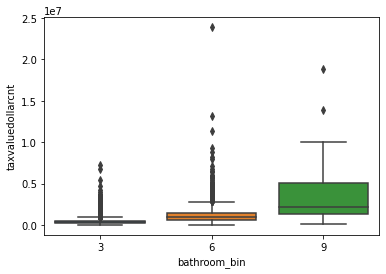

In [9]:
# Visualize relationship between bathroom count and tax value (Continuous and Categorical)
X_train_explore['bathroom_bin'] = pd.cut(X_train_explore.bathroomcnt, bins=[0, 3, 6, 9], labels=['3', '6', '9'])
sns.boxplot(data=X_train_explore, y='taxvaluedollarcnt', x='bathroom_bin')
plt.show()

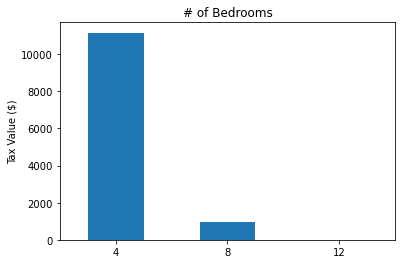

In [10]:
# Histogram of Bedrooms (Continuous and Categorical)

X_train_explore.bedroom_bin.value_counts().sort_index().plot.bar()
plt.title('# of Bedrooms')
plt.ylabel('Tax Value ($)')
plt.xticks(rotation=0)
plt.show()

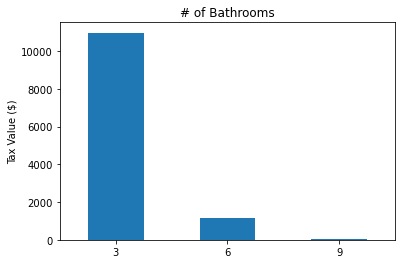

In [11]:
# Histogram of Bedrooms (Continuous and Categorical)
X_train_explore.bathroom_bin.value_counts().sort_index().plot.bar()
plt.title('# of Bathrooms')
plt.ylabel('Tax Value ($)')
plt.xticks(rotation=0)
plt.show()

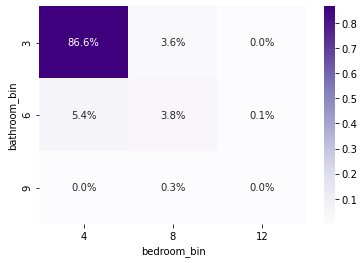

In [12]:
# Heatmap of bined values (Categorical and Categorical)
ctab = pd.crosstab(X_train_explore.bathroom_bin, X_train_explore.bedroom_bin, normalize=True)
sns.heatmap(ctab, cmap='Purples', annot=True, fmt='.1%')

#### Takeaway:

1. The only feature that appears to correlate wth the target in a linear fashion is calculatedfinishedsqure feet
2. Most housese have 3 or less bathrooms
3. Most houses have 3 or less bedrooms
4. High degree of correlation between bedrooms and bathrooms (in lower range of values), relationship to explore

## Evaluate Linear Features

In [13]:
# This is the code for the Linear Model
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression, SelectKBest, RFE 

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5305276391009041.0
Model SSE 3462582594573496.0
SSE is 3462582594573496.0  which is the sum sf squared errors
MSE is 283446512325.9247  which is the average squared error
RMSE is 532396.9499592618  which is the square root of the MSE
R-squared =  0.347
p-value for model significance =  0.0
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


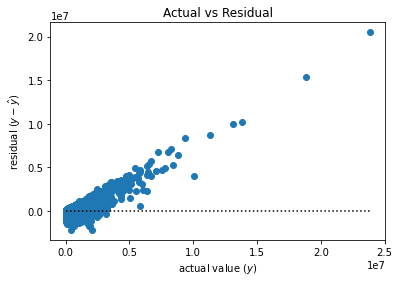

In [14]:
# Evaluate squre feet
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ calculatedfinishedsquarefeet', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.calculatedfinishedsquarefeet)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5305276391009041.0
Model SSE 4963878034789110.0
SSE is 4963878034789110.0  which is the sum sf squared errors
MSE is 406342340765.3168  which is the average squared error
RMSE is 637449.8731393056  which is the square root of the MSE
R-squared =  0.064
p-value for model significance =  1.0998577971646184e-178
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


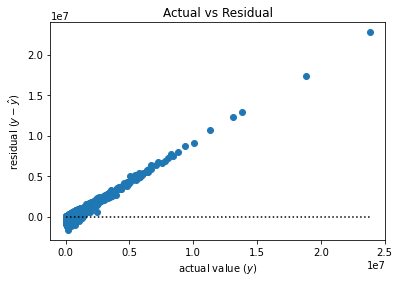

In [15]:
# Evaluate bedroom count
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ bedroomcnt', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.bedroomcnt)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5305276391009041.0
Model SSE 4136701538742535.0
SSE is 4136701538742535.0  which is the sum sf squared errors
MSE is 338629791973.03  which is the average squared error
RMSE is 581919.0596406256  which is the square root of the MSE
R-squared =  0.22
p-value for model significance =  0.0
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


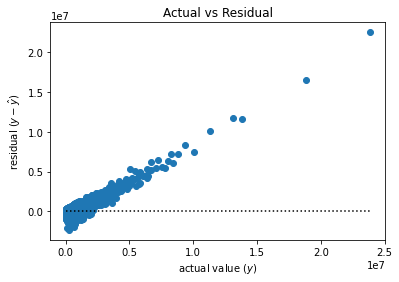

In [16]:
# Evaluate bathroom count

src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ bathroomcnt', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.bathroomcnt)

### Takaway:

- All 3 Variables pass F-test and are significant to use in our modeling

***

## Hypothesis Testing

***

#### Chi Squared Test For Independence:

**Hypothesis: There is a relationship between # of bedrooms and # of bathrooms that would make them a good canidate for future feature engeneering.**

Null Hypothesis: $H_{0}$: Number of Bedrooms and Number of Bathrooms are independent

Alternative Hypothesis: $H_{a}$: Number of Bedrooms and Number of Bathrooms are dependent


In [17]:
# Hypothesis Test

alpha = 0.05
contingency_table = pd.crosstab(X_train_explore.bedroomcnt, X_train_explore.bathroomcnt)

chi2, p, degf, expected = stats.chi2_contingency(contingency_table)

if p < alpha:
    print("We reject the null hypothesis")
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis
chi^2 = 16327.1250
p     = 0.0000


#### Takeaway:

- Num. of bathrooms and Num. of bedrooms are related, and most likely would make an effective combined feature

<div class="alert alert-block alert-success"></div>

# Modeling

Creating 4 Models to run on train dataset
1. Linear Regression
2. LassoLars
3. Polynomial Features
4. TweedieRegressor

In [18]:
# Models
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

### Create a Baseline

In [19]:
# Mean Value
np.mean(y_train)
y_train.shape

(12216, 1)

In [20]:
# encode as variable
# np.full modiefies shape turns value in to a full series object
baseline_rmse = mean_squared_error(y_train, np.full(12216, np.mean(y_train)))**(1/2)
baseline_rmse  # Model Error To Beat $659,000

659006.1919428958

### Specify Variables for Modeling

In [6]:
X_train_scaled.columns


Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fireplace', 'garage', 'hottub_spa', 'lotsizesquarefeet', 'poolcnt',
       'roomcnt', 'zip_cc', 'useid_cc', 'year_cc'],
      dtype='object')

In [21]:
# Only use bedroomcnt, bathroomcnt, and calculatedfinishedsquarefeet
# x df's are all numeric cols except tip
X_train_scaled = X_train_scaled.drop(columns=['fireplace', 'garage', 'hottub_spa', 'lotsizesquarefeet', 'poolcnt',
       'roomcnt', 'zip_cc', 'useid_cc', 'year_cc'])
X_validate_scaled = X_validate_scaled.drop(columns=['fireplace', 'garage', 'hottub_spa', 'lotsizesquarefeet', 'poolcnt',
       'roomcnt', 'zip_cc', 'useid_cc', 'year_cc'])
X_test_scaled = X_test_scaled.drop(columns=['fireplace', 'garage', 'hottub_spa', 'lotsizesquarefeet', 'poolcnt',
       'roomcnt', 'zip_cc', 'useid_cc', 'year_cc'])

In [22]:
X_train_scaled.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'], dtype='object')

***

# Train

***

### Linear Regression

In [23]:
# Make Model
lm = LinearRegression(normalize=True)
# Fit Model
lm.fit(X_train_scaled, y_train)
# Make Predictions
lm_pred = lm.predict(X_train_scaled)
# Compute root mean squared error
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
lm_rmse

520634.5005526053

### LassoLars

In [24]:
# Make a model
lars = LassoLars(alpha=1)
# Fit a model
lars.fit(X_train_scaled, y_train)
# Make Predictions
lars_pred = lars.predict(X_train_scaled)
# Computer root mean squared error
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
lars_rmse

520634.57558119384

### Ploynomial Features

In [43]:
# Make a model
pf = PolynomialFeatures(degree=2)

# Fit and Transform model
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)
X_test_squared = pf.transform(X_test_scaled)

# Feed new features in to linear model. 
lm_squared = LinearRegression()
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred = lm_squared.predict(X_train_squared)
# Compute root mean squared error
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
lm_squared_rmse

503340.82626955677

### Tweedie Regressor

In [26]:
# Make Model
tw = TweedieRegressor(power=0, alpha=0.1) # 0 = normal distribution
# Fit Model
tw.fit(X_train_scaled, y_train)
# Make Predictions
tw_pred = tw.predict(X_train_scaled)
# Compute root mean squared error
tw_rmse = mean_squared_error(y_train, tw_pred)**(1/2)
tw_rmse

635035.2731805356

***

### Takeaway:
- Top 3 preforming models are Linear, LassoLars, and Polynomial
- These modes will move on to Validate

***

# Validate

### Linear Regression

In [27]:
# Make Predictions
lm_pred_v = lm.predict(X_validate_scaled)
# Compute root mean squared error
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**(1/2)
lm_rmse_v

486307.6079205688

### LassoLars

In [28]:
# Make predictions
lars_pred_v = lars.predict(X_validate_scaled)
# Compute root mean squared error
lars_rmse_v = mean_squared_error(y_validate, lars_pred_v)**(1/2)
lars_rmse_v

486303.12943566113

### Ploynomial Features

In [49]:
# Feed new features in to linear model. 
lm_squared = LinearRegression()
lm_squared.fit(X_validate_squared, y_validate)
# Make predictions
lm_squared_pred = lm_squared.predict(X_validate_squared)
# Compute root mean squared error
lm_squared_rmse = mean_squared_error(y_validate, lm_squared_pred)**(1/2)
lm_squared_rmse_v

466010.993109916

***

### Takeaway:
- On unseen data Linear and  LassoLars preformed the test, error decreases indicates no overfitting
- Polynomial model error skyrocketed, indicates overfitt
- Evaluate LassoLars on Test

***

# Test

### LassoLars

In [30]:
# Make Predictions (On best Model)
lars_pred_test = lars.predict(X_test_scaled)
# Compute root mean squared error
lars_rmse_test = mean_squared_error(y_test, lars_pred_test)**(1/2)
lars_rmse_test

496243.1254316465

### Ploynomial Features

In [50]:
# Feed new features in to linear model. 
lm_squared = LinearRegression()
lm_squared.fit(X_test_squared, y_test)
# Make predictions
lm_squared_pred = lm_squared.predict(X_test_squared)
# Compute root mean squared error
lm_squared_rmse_t = mean_squared_error(y_test, lm_squared_pred)**(1/2)
lm_squared_rmse_t

469438.1656676475

#### Average Model Error (Validate + Test) / 2

In [31]:
# Avg. Error = (Validate Error + Test Error) /2 - Average preformance of model works on unseen data
model_error = round((lars_rmse_v + lars_rmse_test) / 2 , 3)
print(f'The average error for our model is ${model_error}')

The average error for our model is $491273.127


In [51]:
# Avg. Error = (Validate Error + Test Error) /2 - Average preformance of model works on unseen data
model_error = round((lm_squared_rmse_v + lm_squared_rmse_t) / 2 , 3)
print(f'The average error for our model is ${model_error}')

The average error for our model is $467724.579


In [32]:
# Calcuating % improvement
# First: work out the difference (increase) between the two numbers you are comparing
difference = (baseline_rmse - lars_rmse_test)
# Then: divide the increase by the original number and multiply the answer by 100
percent_improve = round((difference / baseline_rmse) * 100, 3)
print(f'The % improvement for our model is %{percent_improve}')

The % improvement for our model is %24.698


***

### Takeaway:
- LassoLars is the model that best predicts tax assessed value
- This model produces an average error of $484,311.61 
- This represents a 26% improvement over baseline

***

<div class="alert alert-block alert-success"></div>

# Conclusion

### Summary:


1. Constructed model to predict single unit property tax assessment value
  - Explored 3 variables for modeling (bedroomcnt, bathroomcnt, and calculatedfinishedsquarefeet)
  - Variables passed F-Test with p-value < 0.05, indicating 95% certainty the indipendent variables explains the relationship (r-value)
  - Chi Squared Test for Independence was preformed on bedroomcnt and bathroomcnt
    - Rejected Null, variables are not independent and may be usefull in feature engineering
    
    
2. Model was able to predict home values within an error of $484,301.60
  - This represents a **26% improvement over baseline**

### Recommendations

1. New features for Model: 

   - bedroomcnt, bathroomcnt, and calculatedfinishedsquarefeet all pass F-test with p-value < 0.05, however they are not all great features for developing linear models

   - r-squared values for features ranged between 0.35 (calculatedfinishedsquarefeet) and 0.06 (bedroomcnt), indicating that different features from the dataset might have greater linear correlations and help to build a better model.

   - using a heatmap we were able to identify a high degree of correlation between bedroomcnt and bathroom cnt that was confirmed by our Chi Squared Test of Independence.  Combining these two featues in to a single feature might improve models predictive ability.  

<div class="alert alert-block alert-success"></div>

# Round 2 - Iterations on Model

In [33]:
# Just looking for correlations (.iloc[-5] is location of target)

X_train_explore.corr().iloc[-5]

bathroomcnt                     0.469326
bedroomcnt                      0.253674
calculatedfinishedsquarefeet    0.589349
fips                           -0.001361
fireplace                       0.043943
garage                          0.094503
hottub_spa                      0.161438
latitude                       -0.114307
longitude                      -0.019203
lotsizesquarefeet              -0.014053
poolcnt                         0.168562
roomcnt                         0.000719
taxvaluedollarcnt               1.000000
taxamount                       0.989916
zip_cc                         -0.097189
useid_cc                       -0.073533
year_cc                         0.114001
Name: taxvaluedollarcnt, dtype: float64

#### Takaway:
- Variables with greatest correlation to target
  - bathroomcnt
  - calculatedfinishedsquarefeet
  - hottub_spa
  - poolcnt
  - year_cc

### Evaluate Linear Features (does correlation pass F-Test?)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5305276391009041.0
Model SSE 4136701538742535.0
SSE is 4136701538742535.0  which is the sum sf squared errors
MSE is 338629791973.03  which is the average squared error
RMSE is 581919.0596406256  which is the square root of the MSE
R-squared =  0.22
p-value for model significance =  0.0
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


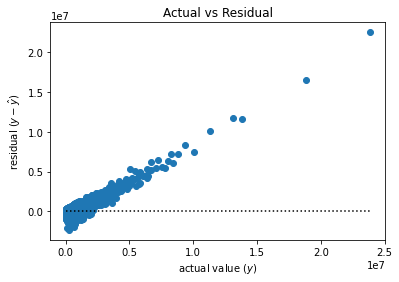

In [34]:
# Evaluate bathroomcnt
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ bathroomcnt', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.bathroomcnt)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5305276391009041.0
Model SSE 3462582594573496.0
SSE is 3462582594573496.0  which is the sum sf squared errors
MSE is 283446512325.9247  which is the average squared error
RMSE is 532396.9499592618  which is the square root of the MSE
R-squared =  0.347
p-value for model significance =  0.0
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


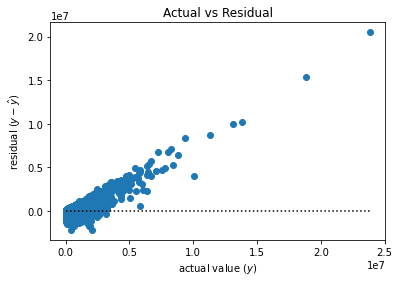

In [35]:
# Evaluate calculatedfinishedsquarefeet
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ calculatedfinishedsquarefeet', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.calculatedfinishedsquarefeet)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5305276391009041.0
Model SSE 5167009711001330.0
SSE is 5167009711001330.0  which is the sum sf squared errors
MSE is 422970670514.1888  which is the average squared error
RMSE is 650361.9534645218  which is the square root of the MSE
R-squared =  0.026
p-value for model significance =  4.070090992567426e-72
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


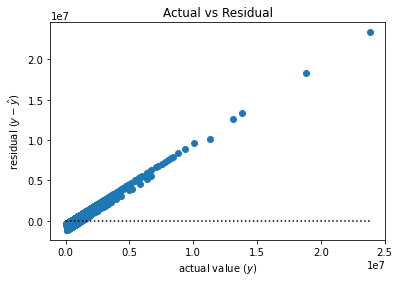

In [36]:
# Evaluate hottub_spa
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ hottub_spa', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.hottub_spa)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5305276391009041.0
Model SSE 5154537184452093.0
SSE is 5154537184452093.0  which is the sum sf squared errors
MSE is 421949671287.82684  which is the average squared error
RMSE is 649576.5322791664  which is the square root of the MSE
R-squared =  0.028
p-value for model significance =  1.5172206952763014e-78
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


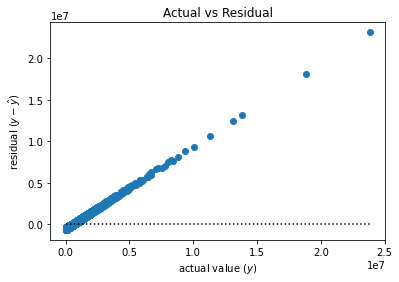

In [37]:
# Evaluate poolcnt
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ poolcnt', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.poolcnt)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5305276391009041.0
Model SSE 5236327303370102.0
SSE is 5236327303370102.0  which is the sum sf squared errors
MSE is 428644998638.67896  which is the average squared error
RMSE is 654709.858363748  which is the square root of the MSE
R-squared =  0.013
p-value for model significance =  1.2695907840530403e-36
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


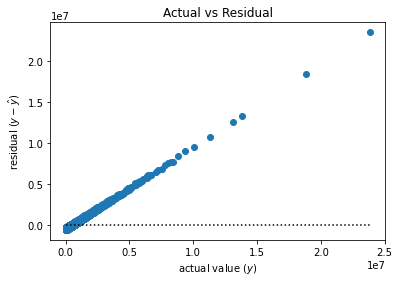

In [38]:
# Evaluate year_cc
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ year_cc', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.year_cc)

#### Takaway:
- All models pass F-Test w/ p-value of < 0.05 and can be used for modeling, however most features just barely beat the model, suggesting they may not improve model preformance

- Even variables with hight correlation, have low r-squred values.  Indicates they are not great fits for building a linear model.

- Points toward feature engineering as way forward, combination of bedroom/bathroom

 # Modeling